# I. Python Librairies

Installation of required Python libraries.

In [1]:
!pip install flopco-pytorch
!pip install tqdm

# II. Dataset

Instructions to setup the COVID-19 Radiography Database:

1. Download the dataset here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/download
2. Unzip the archive and place it into a folder named Dataset next to this Jupyter Notebook.

The folder hierarchy should be:

│   Dataset

│   │   ├── COVID

│   │   │   ├── COVID-.png

│   │   ├── Normal

│   │   │   ├── Normal-.png

│   Notebook



In [2]:
import os

# Prints the class distribution of the COVID-19 Radiography Database.
# The two classes are negative chest x-rays (normal) and positive chest x-rays (COVID-19).

COVID = os.listdir("./Dataset/COVID/")
NORMAL = os.listdir("./Dataset/Normal/")

print("Number of positive Chest X-rays:", len(COVID))
print("Number of negative Chest X-rays:", len(NORMAL))
print("Ratio:", len(COVID)/len(NORMAL))

Number of positive Chest X-rays: 3616
Number of negative Chest X-rays: 10192
Ratio: 0.35478806907378335


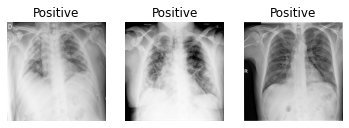

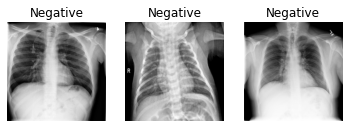

In [3]:
import matplotlib.pyplot as plt

# Shows 3 positive chest x-rays and 3 negative chest x-rays of the COVID-19 Radiography Database.

covid_samples = [COVID[1], COVID[100], COVID[1000]]
normal_samples = [NORMAL[1], NORMAL[100], NORMAL[1000]]

fig = plt.figure()

for i in range(3):
    a = fig.add_subplot(1, 3, i+1)
    image = plt.imread("./Dataset/COVID/" + covid_samples[i])
    plt.imshow(image,cmap='Greys_r')
    plt.title("Positive")
    plt.axis('off')
    
fig = plt.figure()

for i in range(3):
    a = fig.add_subplot(1, 3, i+1)
    image = plt.imread("./Dataset/Normal/" + normal_samples[i])
    plt.imshow(image,cmap='Greys_r')
    plt.title("Negative")
    plt.axis('off')
    
plt.show()

# III. Normalization

Presentation of useful pre-processing techniques using Python Image Library (PIL).

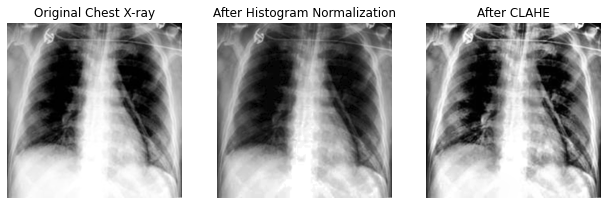

In [4]:
from PIL import Image
from skimage import exposure
import numpy as np

# Normalization techniques

# Reads a chest x-ray.
chest_x_ray = Image.open("./Dataset/COVID/" + COVID[112])
chest_x_ray_array = np.array(chest_x_ray)

# Applies normalization techniques to the chest x-ray.
chest_x_ray_hist = exposure.equalize_hist(chest_x_ray_array) # Histogram normalization
chest_x_ray_clahe = exposure.equalize_adapthist(chest_x_ray_array/np.max(chest_x_ray_array)) # CLAHE normalization

plt.subplot(131)
plt.title("Original Chest X-ray")
plt.imshow(chest_x_ray, cmap='gray')
plt.axis("off")

plt.subplot(132)
plt.title("After Histogram Normalization")
plt.imshow(chest_x_ray_hist, cmap='gray')
plt.axis("off")

plt.subplot(133)
plt.title("After CLAHE")
plt.imshow(chest_x_ray_clahe, cmap='gray')
plt.axis("off")

plt.subplots_adjust(right=1.5)
plt.show()

# IV. Data-augmentation

This section presents the data-augmentation.

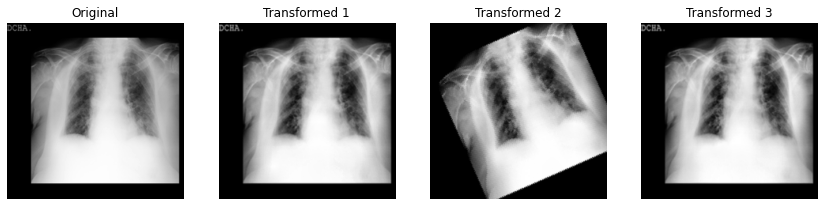

In [5]:
from torchvision import transforms

# CLAHE normalization
# 1. Takes an input image,
# 2. Applies CLAHE,
# 3. Returns the result (RGB).

def clahe(I):
    I = np.array(I) / np.max(I)
    I = exposure.equalize_adapthist(I)
    I = Image.fromarray(np.uint8(I * 255)).convert("RGB")
    return I

# Returns the data-augmentation pipeline
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)), # Resize the images to 224x224
        transforms.RandomApply(
            [transforms.RandomRotation(25), # Random rotation
             transforms.RandomHorizontalFlip()], p=0.5), # Random horizontal flip
        transforms.RandomPerspective(0.3, 0.25), # Random perspective
        transforms.RandomApply([transforms.ColorJitter(brightness=0.25, contrast=0.2)], p=0.5), # Brightness and contrast
        transforms.Lambda(lambda x: clahe(x)), # CLAHE
        transforms.ToTensor()])

data_augmentation = get_transforms()

# Applies the data-augmentation pipeline to 3 chest x-rays. 
chest_x_ray = Image.open("./Dataset/COVID/" + COVID[111])
transformed_chest_x_ray_1 = data_augmentation(chest_x_ray)
transformed_chest_x_ray_2 = data_augmentation(chest_x_ray)
transformed_chest_x_ray_3 = data_augmentation(chest_x_ray)

# Displays the results.
plt.subplot(141)
plt.title("Original")
plt.imshow(chest_x_ray, cmap='gray')
plt.axis("off")

plt.subplot(142)
plt.title("Transformed 1")
plt.imshow(transformed_chest_x_ray_1.permute(1, 2, 0))
plt.axis("off")

plt.subplot(143)
plt.title("Transformed 2")
plt.imshow(transformed_chest_x_ray_2.permute(1, 2, 0))
plt.axis("off")

plt.subplot(144)
plt.title("Transformed 3")
plt.imshow(transformed_chest_x_ray_3.permute(1, 2, 0))
plt.axis("off")

plt.subplots_adjust(right=2)
plt.show()

# V. Models

This section presents the size, MACs and FLOPs of the ResNet 18, DenseNet 121 and MobileNet V2 using the Python Library FlopCo.

In [6]:
from torchvision.models import resnet18, densenet121, mobilenet_v2
from flopco import FlopCo
import torch

# Counts the number of trainable parameters (weights and biases).
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Counts the number of parameters of each network.
print(" 1. Size \n")

print("Resnet 18:", count_parameters(resnet18(num_classes=2)), "parameters")
print("DenseNet 121:", count_parameters(densenet121(num_classes=2)), "parameters")
print("MobileNet V2:", count_parameters(mobilenet_v2(num_classes=2)), "parameters")

# Computes the number of Multiply-Accumulate operations (MAC) and Floating-point operations Per Second (FLOPS) of each model.
print("\n 2. MACs and FLOPs \n")

# ResNet 18
model = resnet18(num_classes=2)
stats = FlopCo(model, img_size = (1, 3, 224, 224), device = 'cpu')
print("ResNet 18", "MACs:", stats.total_macs, "FLOPs:", stats.total_flops)

# DenseNet 121
model = densenet121(num_classes=2)
stats = FlopCo(model, img_size = (1, 3, 224, 224), device = 'cpu')
print("DenseNet 121", "MACs:", stats.total_macs, "FLOPs:", stats.total_flops)

# MobileNet V2
model = mobilenet_v2(num_classes=2)
stats = FlopCo(model, img_size = (1, 3, 224, 224), device = 'cpu')
print("MobileNet V2", "MACs:", stats.total_macs, "FLOPs:", stats.total_flops)

 1. Size 

Resnet 18: 11177538 parameters
DenseNet 121: 6955906 parameters
MobileNet V2: 2226434 parameters

 2. MACs and FLOPs 

ResNet 18 MACs: 1813562368 FLOPs: 3627125248
DenseNet 121 MACs: 2833139712 FLOPs: 5666280448
MobileNet V2 MACs: 299496832 FLOPs: 598994944


# VI. Training

This section introduces useful methods for the training (Section A), trains the models on a balanced subset of the original dataset (Section B), trains the best model on the original dataset (Section C), and shows the results  of the training of section B: average F2 score by GMACs and average F2 score by FLOPs (Section D).

## A. Utilities

In [7]:
from torch.utils.data import Dataset
import random

# PyTorch implementation of the COVID-19 Radiography Database.
# The COVID19 class is Dataset object.

class COVID19(Dataset):

    """
        Initializes the object COVID19.
        Parameters:
            - root_dir (string): Path to the dataset folder.
            - balance (boolean): Indicates the use of the original dataset (false) or the balanced subset (true). Default true.
            - transform (PyTorch transforms object): The data-augmentation pipeline.
        Returns:
            - None
    """ 
    # 
    def __init__(self, root_dir="../Dataset/", balance=True, transform=None):

        # Root directory of CXRs
        self.root_dir = root_dir
        # Balance the dataset: number(covid CXRs) = number(normal CXRs) = 3616
        # Randomly selects 3616 normal CXRs
        self.cxrs = os.listdir(root_dir + "COVID/")
        self.cxrs = [img for img in self.cxrs if img[0] != '.']
        negative = os.listdir(root_dir + "Normal/")
        filtered_negative = [img for img in negative if img[0] != '.']

        if balance:
            self.cxrs += random.choices(filtered_negative, k=3616)
        else:
            self.cxrs += filtered_negative

        # Transforms
        self.transform = None
        if transform:
            self.transform = transform

    """
        Returns the length of the dataset, i.e the number of chest x-rays.
    """
    def __len__(self):
        return len(self.cxrs)

    """
        Returns a sample of the dataset: (name of the chest x-ray, the chest x-ray, label).
        
        Parameters:
            - idx (int): Index of the sample.
            
        Returns:
            - (tuple): (name of the chest x-ray, the chest x-ray, label).
    """
    def __getitem__(self, idx):
        cxr_name = self.cxrs[idx]

        if "COVID" in cxr_name:
            path = self.root_dir + "COVID/"
            label = 1
        else:
            path = self.root_dir + "Normal/"
            label = 0

        cxr = Image.open(path + cxr_name)
        
        if self.transform:
            cxr = self.transform(cxr)
        return cxr_name, cxr, label

    """
        Returns the label of the sample at a given index.
        
        Parameters:
            - idx (int): Index of the sample.
            
        Returns:
            - label (int): 1 if covid, 0 if normal.sv
    """
    def get_target(self, idx):
        cxr_name = self.cxrs[idx]
        
        if "COVID" in cxr_name:
            return 1
        else:
            return 0

In [32]:
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, StratifiedKFold
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import notebook
from timeit import default_timer as timer
from torchvision.models import mobilenet_v2, resnet18, densenet121
from sklearn.metrics import recall_score, precision_score, fbeta_score
import pandas as pd
import numpy as np
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
from collections import Counter

# Runs a 5-fold cross validation
def train_test_k_fold(models, batch_size=32, epochs=5, folds=5, balanced=True):
    
    # The dataset
    dataset = COVID19(balance=balanced, root_dir="./Dataset/", transform=get_transforms())
    
    # The device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # The lists that collect training/testing information
    overall_summary = [] # Metrics of the folds
    fold_metrics = [] # Metrics of the current fold
    confusion_matrices = {} # Aggregate confusion matrices of the models
    
    # Stratified K-Fold
    y = [dataset.get_target(i) for i in range(len(dataset))] # Labels
    x = np.arange(0, len(y), 1) # Indices
    k_fold = StratifiedKFold(folds, shuffle=True) # Stratified K-Fold tool
    positive_cases, negative_cases = 0, 0
    
    # Iterates over the folds
    for fold, (train_idx, test_idx) in enumerate(k_fold.split(x, y)):
        
        # Iterates over the models
        for model_architecture in models:
            
            # Learning rate for the models that are trained from scratch
            lr = 0.01

            # MobileNet V2
            if model_architecture == "mobilenet_v2":
                model = mobilenet_v2(num_classes=1)
                model.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(1280, 1),
                        nn.Sigmoid())

            # Pre-trained MobileNet V2 (on ImageNet)
            elif model_architecture == "mobilenet_v2_PT":
                lr = 0.001
                model = mobilenet_v2(pretrained=True)
                model.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(1280, 1),
                        nn.Sigmoid())
                
            # ResNet 18
            elif model_architecture == "resnet18":
                model = resnet18(num_classes=1)
                model.fc = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(512, 1),
                        nn.Sigmoid())
            
            # Pre-trained ResNet 18 (on ImageNet)
            elif model_architecture == "resnet18_PT":
                lr = 0.001
                model = torchvision.models.resnet18(pretrained=True)
                model.fc = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(512, 1),
                        nn.Sigmoid())
            
            # DenseNet 121
            elif model_architecture == "densenet121":
                model = densenet121(num_classes=1)
                model.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(1024, 1),
                        nn.Sigmoid())
                
            # Pre-trained DenseNet 121 (on ImageNet)
            elif model_architecture == "densenet121_PT":
                lr = 0.001
                model = densenet121(pretrained=True)
                model.classifier = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(1024, 1),
                        nn.Sigmoid())

            model.to(device)
            
            criterion = nn.BCELoss() # Binary Cross Entropy Loss
            optimizer = Adam(model.parameters(), lr=lr) # Adam optimizer

            print("Fold {} - {}".format(fold + 1, model_architecture))
            train_sampler = SubsetRandomSampler(train_idx) 
            test_sampler = SubsetRandomSampler(test_idx)

            train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler) # Train loader
            test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler) # Test loader
            
            # Iterates over the epochs
            for epoch in range(1, epochs + 1):
                model.train()

                running_loss = 0.0 # Epoch loss (updated after each batch)
                running_predictions = 0.0 # Epoch accuracy (updated after each batch)
                total_predictions = 0.0 # Number of predictions (updated after each batch)
                batch = 1

                with notebook.tqdm(train_loader, unit="batch") as t_epoch:

                    t_epoch.set_description(f"Epoch {epoch}" + "/{}".format(epochs))
                    
                    # Iterates over a batch
                    for _, images, labels in t_epoch:
                        images = images.to(device)
                        labels = labels.to(device)
                        labels = labels.to(torch.float32)
                        labels = labels.unsqueeze(1)

                        optimizer.zero_grad()
                        output = model(images)
                        loss = criterion(output, labels)

                        predicted = torch.round(output)

                        total_predictions += len(labels)
                        batch_predictions = (predicted == labels).sum().item()
                        running_predictions += batch_predictions

                        running_loss += loss.item()

                        t_epoch.set_postfix(loss=running_loss / batch, 
                                            accuracy=100 * (running_predictions / total_predictions))

                        loss.backward()
                        optimizer.step()

                        batch += 1
                                        
            model.eval()
            predictions = []
            true_values = []
            
            # Test the model
            with torch.no_grad():
                with notebook.tqdm(test_loader, unit="batch") as t_epoch:
                    for _, images, labels in t_epoch:
                        images = images.to(device)
                        labels = labels.to(device)
                        optimizer.zero_grad()
                        output = model(images)
                        
                        predicted = torch.round(output)

                        true_values.append(labels.detach().cpu().item())
                        predictions.append(predicted.detach().cpu().item())
            
            # Metrics
            recall = np.around(recall_score(true_values, predictions), 2)
            precision = np.around(precision_score(true_values, predictions), 2)
            f_beta_score = np.around(fbeta_score(true_values, predictions, beta=2), 2)
            cf_matrix = confusion_matrix(true_values, predictions)

            # Sums the confusion matrices
            if model_architecture not in confusion_matrices:
                confusion_matrices[model_architecture] = cf_matrix
            else:
                confusion_matrices[model_architecture] = confusion_matrices[model_architecture] + cf_matrix
                
            fold_metrics += [
                pd.DataFrame([[model_architecture, fold + 1, recall, precision, f_beta_score]],
                             columns=["Model", "Fold", "Recall", "Precision", "F2"])]
            print("\n")
            positive_cases += Counter(true_values)[1]
            negative_cases += Counter(true_values)[0]
            
            overall_summary = pd.concat(fold_metrics, ignore_index=True)
            display(overall_summary)
            print("\n")
    
    # Displays the cumulated confusion matrices
    for model in models:
        s = np.sum(confusion_matrices[model])
               
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[model]/s, display_labels=["Not infected", "Infected"])
        disp.plot(cmap="Blues")
        
        title = "cm_{}".format(model)
        
        if balanced == False:
            title = "original"
            
        print("Confusion matrix of", model)
        plt.savefig(title)
        plt.show()
    
    description = "results"
    
    if balanced == False:
        description = "original"
        print("Positive cases:", positive_cases)
        print("Negative cases:", negative_cases)

    overall_summary.to_csv("{}.csv".format(description))    

## B. Balanced Subset

This sub-section trains a ResNet 18 (from scratch and pre-trained on ImageNet), DenseNet 121 (from scratch and pre-trained on ImageNet) and MobileNet V2 (from scratch and pre-trained on ImageNet) on a balanced subset of the COVID-19 Radiography Database. The training is a 5-fold cross validation. The number of epochs per iteration is set to 5. 

Fold 1 - densenet121_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.9,0.96




Fold 1 - densenet121


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84




Fold 1 - mobilenet_v2_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96




Fold 1 - mobilenet_v2


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54




Fold 1 - resnet18_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93




Fold 1 - resnet18


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89




Fold 2 - densenet121_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03




Fold 2 - densenet121


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87




Fold 2 - mobilenet_v2_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97




Fold 2 - mobilenet_v2


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 2 - resnet18_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 2 - resnet18


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1447 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - densenet121_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - densenet121


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - mobilenet_v2_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - mobilenet_v2


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - resnet18_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 3 - resnet18


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - densenet121_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - densenet121


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - mobilenet_v2_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - mobilenet_v2


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - resnet18_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 4 - resnet18


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - densenet121_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - densenet121


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - mobilenet_v2_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - mobilenet_v2


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - resnet18_PT


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Fold 5 - resnet18


  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/181 [00:00<?, ?batch/s]

  0%|          | 0/1446 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,densenet121_PT,1,0.98,0.90,0.96
1,densenet121,1,0.99,0.52,0.84
2,mobilenet_v2_PT,1,0.96,0.98,0.96
3,mobilenet_v2,1,0.48,0.96,0.54
4,resnet18_PT,1,0.94,0.92,0.93
5,resnet18,1,0.97,0.66,0.89
6,densenet121_PT,2,0.02,1.00,0.03
7,densenet121,2,0.91,0.72,0.87
8,mobilenet_v2_PT,2,0.98,0.94,0.97
9,mobilenet_v2,2,0.92,0.82,0.90




Confusion matrix of densenet121_PT


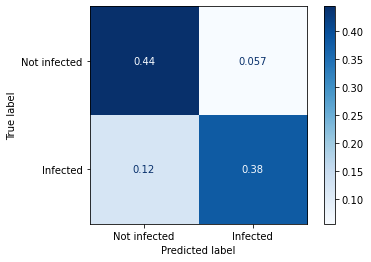

Confusion matrix of densenet121


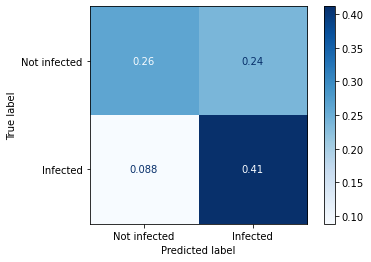

Confusion matrix of mobilenet_v2_PT


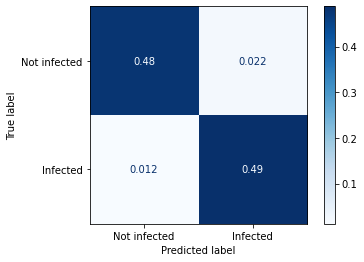

Confusion matrix of mobilenet_v2


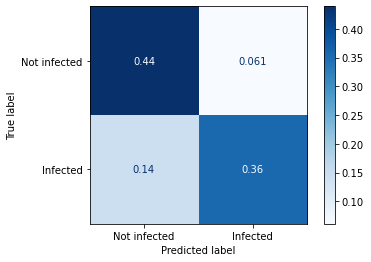

Confusion matrix of resnet18_PT


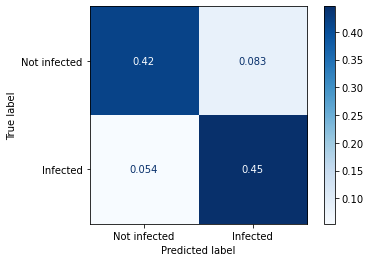

Confusion matrix of resnet18


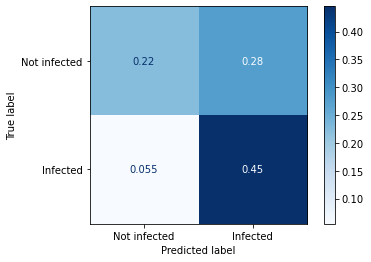

In [11]:
train_test_k_fold(["densenet121_PT", "densenet121", "mobilenet_v2_PT", "mobilenet_v2", "resnet18_PT", "resnet18"])

## C. Original Dataset

This sub-section trains the MobileNet V2 (pre-trained on ImageNet) on the COVID-19 Radiography Database. The training is a 5-fold cross validation. The number of epochs per iteration is set to 10. 

Fold 1 - mobilenet_v2_PT


  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/2762 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,mobilenet_v2_PT,1,0.96,0.98,0.96




Fold 2 - mobilenet_v2_PT


  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/2762 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,mobilenet_v2_PT,1,0.96,0.98,0.96
1,mobilenet_v2_PT,2,0.98,0.82,0.95




Fold 3 - mobilenet_v2_PT


  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/2762 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,mobilenet_v2_PT,1,0.96,0.98,0.96
1,mobilenet_v2_PT,2,0.98,0.82,0.95
2,mobilenet_v2_PT,3,0.93,0.88,0.92




Fold 4 - mobilenet_v2_PT


  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/2761 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,mobilenet_v2_PT,1,0.96,0.98,0.96
1,mobilenet_v2_PT,2,0.98,0.82,0.95
2,mobilenet_v2_PT,3,0.93,0.88,0.92
3,mobilenet_v2_PT,4,0.94,0.96,0.95




Fold 5 - mobilenet_v2_PT


  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/346 [00:00<?, ?batch/s]

  0%|          | 0/2761 [00:00<?, ?batch/s]

,Model,Fold,Recall,Precision,F2
0,mobilenet_v2_PT,1,0.96,0.98,0.96
1,mobilenet_v2_PT,2,0.98,0.82,0.95
2,mobilenet_v2_PT,3,0.93,0.88,0.92
3,mobilenet_v2_PT,4,0.94,0.96,0.95
4,mobilenet_v2_PT,5,0.94,0.98,0.95




Confusion matrix of mobilenet_v2_PT


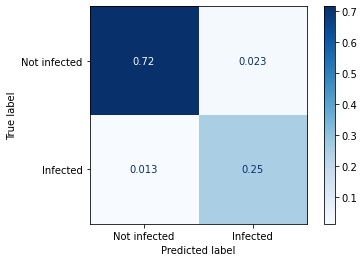

Positive cases: 3616
Negative cases: 10192


In [33]:
train_test_k_fold(["mobilenet_v2_PT"], epochs=10, folds=5, balanced=False)

## D. Results 

This section shows the average F2 score by the MACs and FLOPs of each model. 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# MACs computed before
macs = {
    "resnet18": 1.81,
    "resnet18_PT": 1.81,
    "densenet121": 2.83,
    "densenet121_PT": 2.83,
    "mobilenet_v2": 0.30,
    "mobilenet_v2_PT":0.30
}

# FLOPs computed before
flops = {
     "resnet18": 3.62,
    "resnet18_PT": 3.62,
    "densenet121": 5.67,
    "densenet121_PT": 5.67,
    "mobilenet_v2": 0.60,
    "mobilenet_v2_PT":0.60
}

# Usefull for the legend
names = {
    "resnet18": "ResNet 18",
    "resnet18_PT": "Pre-trained ResNet 18",
    "densenet121": "DenseNet 121",
    "densenet121_PT": "Pre-trained DenseNet 121",
    "mobilenet_v2": "MobileNet V2",
    "mobilenet_v2_PT": "Pre-trained MobileNet V2"
}

In [29]:

def analyze(path_to_results):
    
    # Open the .csv file
    results = pd.read_csv(path_to_results)
    results = results.drop(columns=["Unnamed: 0"])  # Drop useless column

    # Get the model architectures
    label = np.unique(results["Model"].tolist())
    
    fig, ax = plt.subplots()

    for model in label:
        m = results[results["Model"] == model]
        y = m["F2"].tolist()
        ax.scatter(macs[model], np.mean(y), s=100, label=names[model], marker='^', cmap="Paired", alpha=0.5)

    plt.title("Average F2 score by the number of GMACs")
    plt.xlabel("GMAC")
    plt.ylabel("F2")
    ax.set_ylim([0, 1])
    ax.xaxis.set_tick_params(size=0)
    ax.yaxis.set_tick_params(size=0)
    plt.legend()
    
    fig, ax = plt.subplots()

    for model in label:
        m = results[results["Model"] == model]
        y = m["F2"].tolist()
        ax.scatter(flops[model], np.mean(y), s=100, label=names[model], marker='^',  cmap="Paired", alpha=0.5)

    plt.title("Average F2 score by the number of FLOPs")
    plt.xlabel("FLOP")
    plt.ylabel("F2")


    ax.xaxis.set_tick_params(size=0)
    ax.yaxis.set_tick_params(size=0)
    ax.set_ylim([0, 1])
    
    plt.legend()
    plt.show()

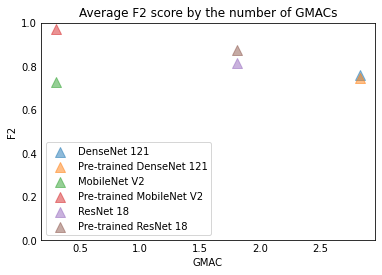

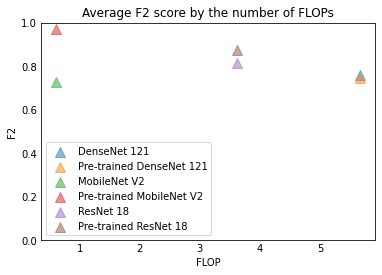

In [35]:
analyze("results.csv")